In [42]:
import sys # for automation and parallelization: set manual to false when run by a launcher
import json
default = {'scenario': 'port-moresby', 'training_folder':'../..'} # Default execution parameters
manual, argv = (True, default) if 'ipykernel' in sys.argv[0] else (False, dict(default, **json.loads(sys.argv[1])))

In [43]:
import os
import time
import geopandas as gpd
import pandas as pd
import numpy as np
sys.path.insert(0, r'../../../quetzal') # Add path to quetzal
from sklearn.neighbors import NearestNeighbors
from numba import jit, njit
import numba as nb
from quetzal.model import stepmodel
from shapely.geometry import LineString
from quetzal.io.gtfs_reader.importer import get_epsg
from quetzal.io import excel
on_lambda = bool(os.environ.get('AWS_EXECUTION_ENV'))
num_cores = nb.config.NUMBA_NUM_THREADS
print('num cores:',num_cores)

io_engine= 'pyogrio' if on_lambda else 'pyogrio' #or fiona

num cores: 8


In [44]:
from syspy.skims.skims import euclidean

In [45]:
scenario = argv['scenario']

on_lambda = bool(os.environ.get('AWS_EXECUTION_ENV'))
print('On Lambda : ', on_lambda)

training_folder = argv['training_folder']
input_folder = training_folder +r'/inputs/'

if not on_lambda:
    scenario_folder = training_folder + '/scenarios/' + scenario  + '/inputs/'
    output_folder = training_folder + '/scenarios/' + scenario  + '/outputs/'
    model_folder = training_folder + '/scenarios/' + scenario  + '/model/'
else:
    scenario_folder = input_folder
    output_folder = training_folder + '/outputs/'
    model_folder = training_folder + '/model/'
print('input folder: ', input_folder)
print('output folder: ', output_folder)
print('scen folder : ', scenario_folder)
print('model folder : ', model_folder)

On Lambda :  False
input folder:  ../../inputs/
output folder:  ../../scenarios/port-moresby/outputs/
scen folder :  ../../scenarios/port-moresby/inputs/
model folder :  ../../scenarios/port-moresby/model/


In [46]:
if 'params' in argv.keys():
    scenario = argv['params']['general']['scenario'] #'params':{'general':{'scenario':'ref2023'}}
    var = excel.read_var(file=input_folder+'parameters.xlsx', scenario=scenario, return_ancestry=False)
    var.update(pd.DataFrame.from_dict(argv['params'], orient="index").stack())
else:
    var = excel.read_var(file=input_folder+'parameters.xlsx', scenario=scenario, return_ancestry=False)

In [47]:
motor_rate = var['generation']['motor_rate'] 
pt_rate = (1-motor_rate)

# Import model

In [48]:
sm = stepmodel.read_zippedpickles(model_folder +'aon_los')

zones: 100%|██████████| 5/5 [00:00<00:00, 1370.87it/s]


In [49]:
pop_mobility = var['generation']['pop_mobility']
job_mobility = var['generation']['job_mobility']

if var['generation']['all_period']:
    to_day =  var['generation']['to_day']
else:
    to_day = 1


sm.zones['emission'] =  sm.zones['population'] * pop_mobility *to_day
sm.zones['attraction'] =  sm.zones['jobs']  * job_mobility *to_day
sm.zones.sort_index(inplace=True)

car = sm.copy()
car.zones[['attraction','emission']] *= motor_rate  
car.zones = car.zones.loc[car.car_los["origin"].unique()]

pt_captive = sm.copy()
pt_captive.zones[['attraction','emission']] *= pt_rate
pt_captive.zones = pt_captive.zones.loc[pt_captive.pt_los["origin"].unique()]

In [50]:
def create_impendance_matrix(df,mode=None, b=None, n=None):
    #time devient en minute comme dans modelling transport
    cost_matrix =  df[ 
    ['origin', 'destination', 'time']
].set_index(['origin','destination']).unstack()
    
    cost_matrix = cost_matrix.replace(0,var['step_distribution']['time_intrazonal_{}'.format(mode)] ) 
    if n == None: n = var["step_distribution"]["n_{}".format(mode)]
    if b == None: b = var["step_distribution"]["b_{}".format(mode)]
    f_cost_matrix = cost_matrix.pow(n) * np.exp(- b *cost_matrix)
    
    #enorme temps pour detruire od sans tc dans pt captif
    f_cost_matrix = f_cost_matrix.fillna(1e16)
    
    imp_matrix = f_cost_matrix 
    
    return( imp_matrix )

In [51]:
from syspy.skims.skims import euclidean

distances = euclidean(sm.zones, coordinates_unit='meter', epsg=4326)
distances['time'] = distances['euclidean_distance'] / 5 + 300
distances.loc[distances['origin'] == distances['destination'], 'time']=1800

In [52]:
e = create_impendance_matrix(car.car_los,'car')
e = e.sort_index(axis=0).sort_index(axis=1)
car.zones.sort_index(inplace=True)
e.sort_index(axis=1, inplace=True)
e.sort_index(axis=0, inplace=True)
car.step_distribution(deterrence_matrix = e) 

In [53]:
e = create_impendance_matrix(pt_captive.pt_los,'pt')
e = e.sort_index(axis=0).sort_index(axis=1)
e.sort_index(axis=1, inplace=True)
e.sort_index(axis=0, inplace=True)
pt_captive.step_distribution(deterrence_matrix = e) 

In [54]:
sm.volumes = pd.merge(
    car.volumes, 
    pt_captive.volumes,
    on=['origin', 'destination'],
    suffixes=[ '_car_owner', '_pt_captive']
).rename(columns={'volume_car_owner': 'car_owner', 'volume_pt_captive': 'pt_captive'})


In [55]:
sm.sample_volumes(bidimentional_sampling=True, fit_sums=True, sample_weight={'car_owner':50, 'pt_captive':5}, sample_size=None, inplace=True)

In [56]:
od_file = scenario_folder + 'od/od.geojson'
od_file_provided = os.path.isfile(od_file)
if od_file_provided:
    
    od_test = gpd.read_file(od_file)
    if 'name' not in od_test.columns:
        od_test['name'] = od_test['index']
    od_test['name'] = od_test['name'].fillna(od_test['index'].astype(str))
    from shapely.geometry import Point
    from syspy.spatial.spatial import nearest, agglomerative_clustering, voronoi_diagram_dataframes, add_geometry_coordinates
    od_test['geometry_o'] = od_test['geometry'].apply(lambda g: Point(g.coords[:][0]))
    od_test['geometry_d'] = od_test['geometry'].apply(lambda g: Point(g.coords[:][1]))
    # find nearest node with KNN. nodes are now the origin and destination.
    od_test['geometry'] = od_test['geometry_o']
    neigh = nearest(od_test, sm.zones.to_crs(4326), n_neighbors=1).rename(columns={'ix_one': 'zone_index', 'ix_many': 'node_index'})
    zone_node_dict = neigh.set_index('zone_index')['node_index'].to_dict()
    od_test['origin'] = od_test.index.map(zone_node_dict.get)

    od_test['geometry'] = od_test['geometry_d']
    neigh = nearest(od_test, sm.zones.to_crs(4326), n_neighbors=1).rename(columns={'ix_one': 'zone_index', 'ix_many': 'node_index'})
    zone_node_dict = neigh.set_index('zone_index')['node_index'].to_dict()
    od_test['destination'] = od_test.index.map(zone_node_dict.get)

    od_test = od_test.drop(columns=['geometry_o','geometry_d','geometry'])
    od_test["pt_captive"] = 0.001
    #Add od_test to volumes after sparsification
    sm.volumes = pd.concat([sm.volumes,od_test[["origin","destination","pt_captive"]]]).sort_values(by="pt_captive",ascending = False).drop_duplicates(["origin","destination"])


    sm.volumes= pd.concat([sm.volumes,od_test[["origin","destination","pt_captive"]]]).sort_values(by="pt_captive",ascending = False).drop_duplicates(["origin","destination"])

In [57]:
sm.volumes = sm.volumes.fillna(0)

In [58]:
sm.to_zippedpickles(model_folder +'distribution', only_attributes= ['volumes', 'zones_before_clustering'])

volumes: 100%|██████████| 12/12 [00:00<00:00, 1712.31it/s]


In [59]:
if var["calibration"]["sortie"] == False:
    end_of_notebook

# Calibration

In [60]:
from syspy.spatial.spatial import nearest_geometry
import math
import matplotlib.pyplot as plt
from syspy.skims.skims import euclidean

In [61]:
def from_zone_before_clustering_to_zone(df,zones):
    df_calib = df.merge(zones,left_on = "origin", right_index = True, how = "left")
    df_calib = df_calib.merge(zones,left_on = "destination", right_index = True, how = "left",suffixes = ("_origin","_destination"))
    df_calib = df_calib[["cluster_origin","cluster_destination","volumes_calibration"]].rename(columns = {"cluster_origin" : "origin","cluster_destination" : "destination"})
    return(df_calib)
    
    return(df[["ratio", 'cluster']])
def near_nodes(nodes,zones,div_neighbors = 2):
    node_proxim = nearest_geometry(nodes,zones,n_neighbors = int(len(zones)/div_neighbors),n_neighbors_centroid = int(len(zones)/div_neighbors))
    node_proxim = node_proxim.sort_values(by = "actual_distance")
    node_proxim =  node_proxim.drop_duplicates(["ix_one"])
    return(node_proxim.set_index(["ix_one"])["ix_many"].to_dict())
def GEH(A, B):
    return ((2*(A-B)**2)/(A+B)).apply(math.sqrt)
def round_up(n, decimals=0):
    multiplier = 10**decimals/2
    return math.ceil(n * multiplier) / multiplier

In [62]:
zones_before_clustering = sm.zones_before_clustering.copy()
zones_before_clustering["cluster"] = 'zone_' + zones_before_clustering["cluster"].astype(str) 
zones = zones_before_clustering

In [63]:
sm.volumes = sm.volumes.fillna(0)
sm.volumes['volumes_model'] = sm.volumes['car_owner'] + sm.volumes['pt_captive']
sm.volumes = sm.volumes.groupby(['origin', 'destination']).sum()
sm.volumes = sm.volumes.reset_index()

# import donées calibration

In [64]:
calib_file = scenario_folder  + r'calibration/volume_od_calibration.csv'
calib_file_provided = os.path.isfile(calib_file)
if calib_file_provided:
    vol_od_calibration = pd.read_csv(calib_file)
    columns = ["volumes_model","volumes_calibration"]
    vol_od_calibration = from_zone_before_clustering_to_zone(vol_od_calibration,zones)
    vol_od_calibration = vol_od_calibration.dropna()
else :
    columns = ["volumes_model"]

### macrozones

In [65]:
macro_file = scenario_folder  + r'calibration/zones_macro.geojson'
macro_file_provided = os.path.isfile(macro_file)
if macro_file_provided:
    import shapely as shp
    macro_zones = gpd.read_file(macro_file).to_crs(sm.zones.crs)

    macro_zones = macro_zones.groupby("macro_zones")['geometry'].apply(shp.ops.cascaded_union)
    centroid = gpd.GeoDataFrame(sm.zones.centroid).rename(columns = {0:"geometry"})
    
    dico_macro_zones = near_nodes(centroid,macro_zones)

nearest_link: 100%|██████████| 464/464 [00:00<00:00, 246348.99it/s]


### distance

In [66]:
origins = sm.volumes['origin'].unique().tolist()
destinations = sm.volumes['destination'].unique().tolist()

distances = euclidean(sm.zones, coordinates_unit='meter', epsg=4326, origins=origins, destinations=destinations)
distances['euclidean_distance'] = (distances['euclidean_distance']/1000).apply(lambda x: round_up(x,var['generation_calibration']['decimal_dist']))

# generation

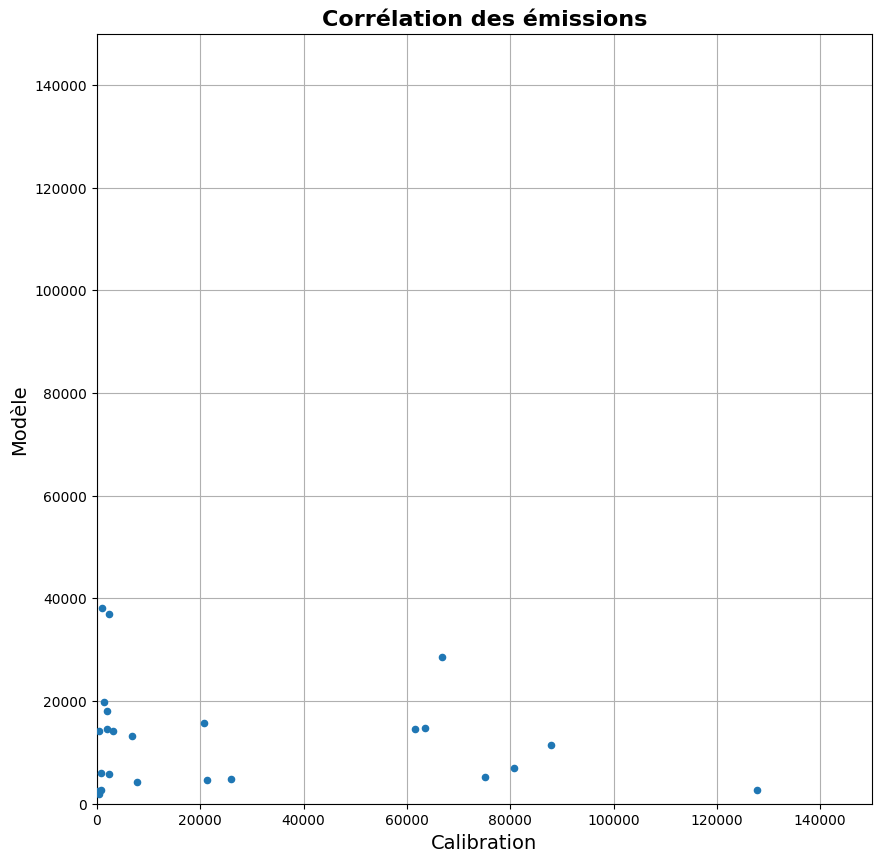

In [67]:
if calib_file_provided:
    sm.zones['emission_calibration'] = vol_od_calibration.groupby(['origin']).sum()
    sm.zones['attraction_calibration'] = vol_od_calibration.groupby(['destination']).sum()
    
    to_plot=sm.zones
    ax =  to_plot.plot.scatter(x='emission_calibration', y='emission', figsize=[10, 10], zorder=3, cmap='viridis', vmin=0, vmax=25)
    ax.grid(axis='both', zorder=3)
    plt.title('Corrélation des émissions',loc='center', fontsize=16, fontweight="bold")
    plt.xlabel('Calibration', fontsize=14)
    plt.ylabel('Modèle', fontsize=14)
    ax.set_xlim(0,150000)
    ax.set_ylim(0,150000)
    fig = ax.get_figure()
    plt.savefig(output_folder+'Comparaison_emissions',bbox_inches='tight', dpi=150)

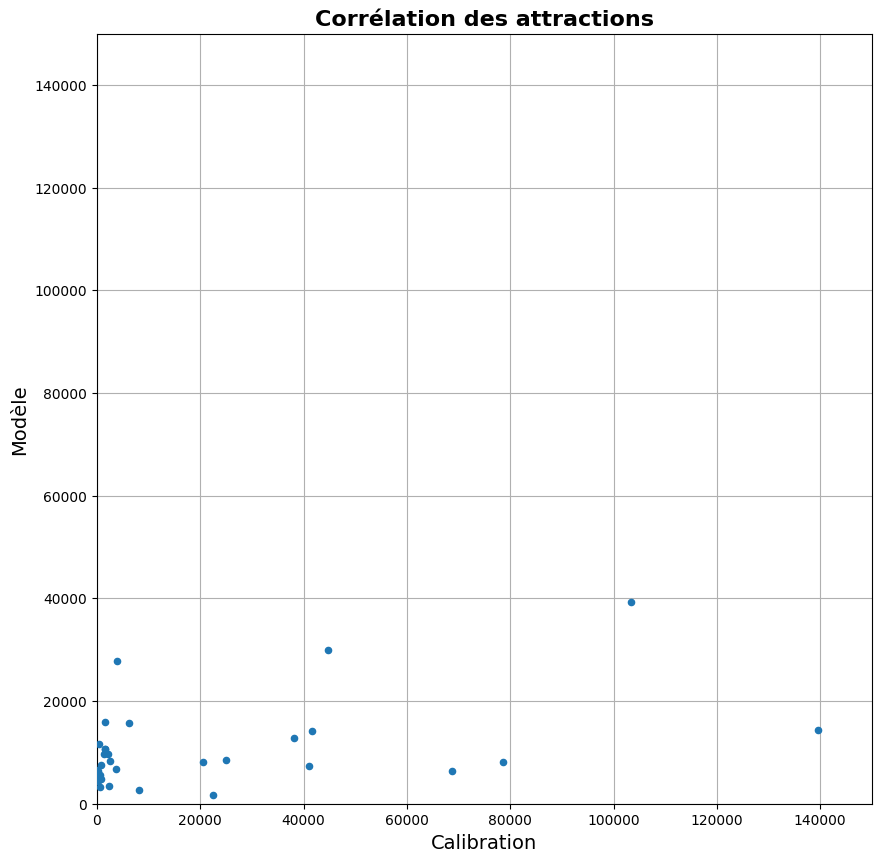

In [68]:
if calib_file_provided:
    to_plot=sm.zones
    ax =  to_plot.plot.scatter(x='attraction_calibration', y='attraction', figsize=[10, 10], zorder=3, cmap='viridis', vmin=0, vmax=25)
    ax.grid(axis='both', zorder=3)
    plt.title('Corrélation des attractions',loc='center', fontsize=16, fontweight="bold")
    plt.xlabel('Calibration', fontsize=14)
    plt.ylabel('Modèle', fontsize=14)
    ax.set_xlim(0,150000)
    ax.set_ylim(0,150000)
    fig = ax.get_figure()
    plt.savefig(output_folder+'Comparaison_attractions',bbox_inches='tight', dpi=150)

In [69]:
sm.zones.corr()

,density,population,jobs,emission,attraction,emission_calibration,attraction_calibration
density,1.000000,0.624920,0.095478,0.624920,0.095478,-0.196430,-0.146314
population,0.624920,1.000000,0.332071,1.000000,0.332071,-0.152125,-0.197220
jobs,0.095478,0.332071,1.000000,0.332071,1.000000,0.367586,0.427767
emission,0.624920,1.000000,0.332071,1.000000,0.332071,-0.152125,-0.197220
attraction,0.095478,0.332071,1.000000,0.332071,1.000000,0.367586,0.427767
emission_calibration,-0.196430,-0.152125,0.367586,-0.152125,0.367586,1.000000,0.952640
attraction_calibration,-0.146314,-0.197220,0.427767,-0.197220,0.427767,0.952640,1.000000


## Volume totaux

In [70]:
# paramètres utilisables pour modifier
var["generation"]

parameter
motor_rate       0.15
pop_mobility      1.0
job_mobility      1.0
to_day              4
all_period      False
Name: port-moresby, dtype: object

In [71]:
if calib_file_provided:
    print(' Calibration:'+ (vol_od_calibration["volumes_calibration"].sum().round(-4)).astype(str) + '\n','Model:'+ sm.volumes['volumes_model'].sum().round(-4).astype(str) + '\n','Rapport Calibration/Model:' + ((vol_od_calibration['volumes_calibration'].sum()/sm.volumes['volumes_model'].sum()).round(3)).astype(str) + '\n' )

else: 
     print('Model:'+ sm.volumes['volumes_model'].sum().round(-4).astype(str))

 Calibration:660000.0
 Model:720000.0
 Rapport Calibration/Model:0.915



# comparaison OD 

In [72]:
# paramètres utilisables pour modifier
var["step_distribution"]

parameter
n_car                     1
n_pt                      1
b_car                     0
b_pt                      0
time_intrazonal_car    1200
time_intrazonal_pt     1200
Name: port-moresby, dtype: object

In [73]:
if calib_file_provided:
    comp_volumes = vol_od_calibration.groupby(["origin","destination"]).sum().reset_index().merge(sm.volumes[['origin', 'destination','volumes_model']], on = ['origin', 'destination'], how= 'outer')
    if macro_file_provided:
            comp_volumes_macro = comp_volumes.copy()
            comp_volumes_macro["origin"] = comp_volumes_macro["origin"].apply(lambda x : dico_macro_zones[x])
            comp_volumes_macro["destination"] = comp_volumes_macro["destination"].apply(lambda x : dico_macro_zones[x])
            comp_volumes_macro = comp_volumes_macro.groupby(["origin", "destination"], as_index=False)[columns].sum()
            comp_volumes_macro.corr()
else:
    comp_volumes = sm.volumes[['origin', 'destination','volumes_model']]


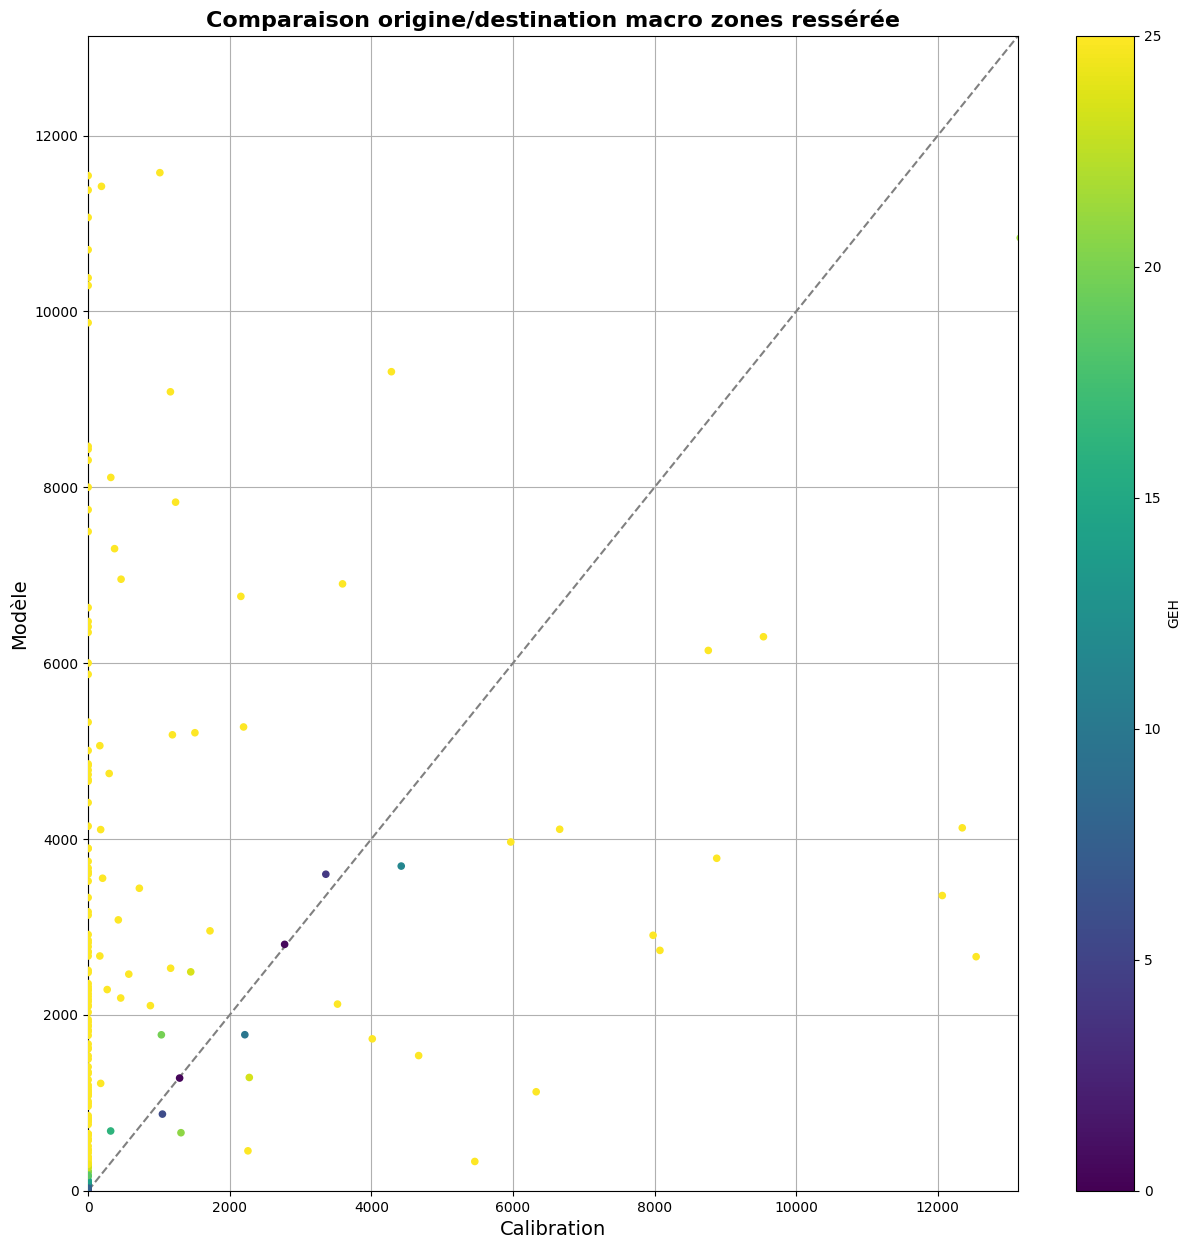

In [74]:
if calib_file_provided and macro_file_provided: 
    to_plot = comp_volumes_macro.set_index(['origin', 'destination'])
    ycol= 'volumes_model'
    xcol= 'volumes_calibration'
    to_plot['GEH'] = GEH(to_plot[ycol], to_plot[xcol])
    ax =  to_plot.plot.scatter(x=xcol, y=ycol, c='GEH', figsize=[15, 15], zorder=3, cmap='viridis', vmin=0, vmax=25)

    t = np.arange(0., max(to_plot[xcol].max(),to_plot[ycol].max()) +500, 1)
    plt.plot(t,t,linestyle='--',color="Grey", zorder=2)
    plt.xlim([0., max(to_plot[xcol].quantile(0.95),to_plot[ycol].quantile(0.95))+500])
    plt.ylim([0., max(to_plot[xcol].quantile(0.95),to_plot[ycol].quantile(0.95))+500])
    plt.xlabel('Calibration', fontsize=14)
    plt.ylabel('Modèle', fontsize=14)
    
    ax.grid(axis='both', zorder=3)
    plt.title('Comparaison origine/destination macro zones ressérée', loc='center', fontsize=16, fontweight="bold")
    fig = ax.get_figure()
    plt.savefig(output_folder+'Comparaison_od_ressérée.png',bbox_inches='tight', dpi=150)

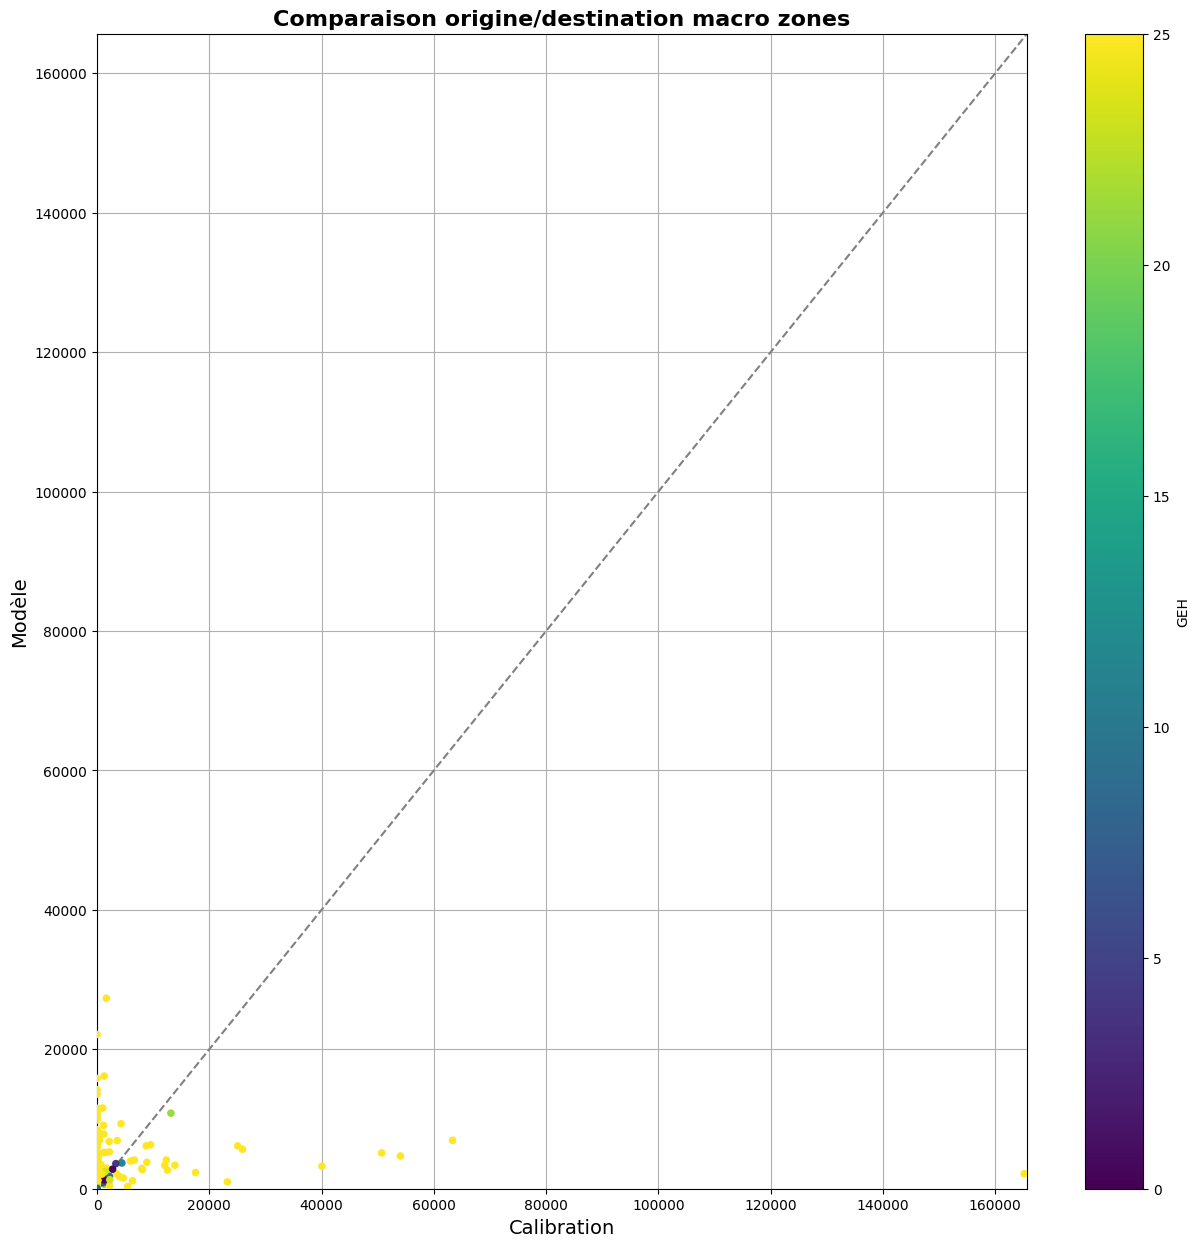

In [75]:
if calib_file_provided and macro_file_provided: 
    to_plot = comp_volumes_macro.set_index(['origin', 'destination'])
    ycol= 'volumes_model'
    xcol= 'volumes_calibration'
    to_plot['GEH'] = GEH(to_plot[ycol], to_plot[xcol])
    ax =  to_plot.plot.scatter(x=xcol, y=ycol, c='GEH', figsize=[15, 15], zorder=3, cmap='viridis', vmin=0, vmax=25)

    t = np.arange(0., max(to_plot[xcol].max(),to_plot[ycol].max()) +500, 1)
    plt.plot(t,t,linestyle='--',color="Grey", zorder=2)
    plt.xlim([0., max(to_plot[xcol].max(),to_plot[ycol].max())+500])
    plt.ylim([0., max(to_plot[xcol].max(),to_plot[ycol].max())+500])
    plt.xlabel('Calibration', fontsize=14)
    plt.ylabel('Modèle', fontsize=14)
    
    ax.grid(axis='both', zorder=3)
    plt.title('Comparaison origine/destination macro zones', loc='center', fontsize=16, fontweight="bold")
    
    fig = ax.get_figure()
    plt.savefig(output_folder+'Comparaison_od_macro.png',bbox_inches='tight', dpi=150)

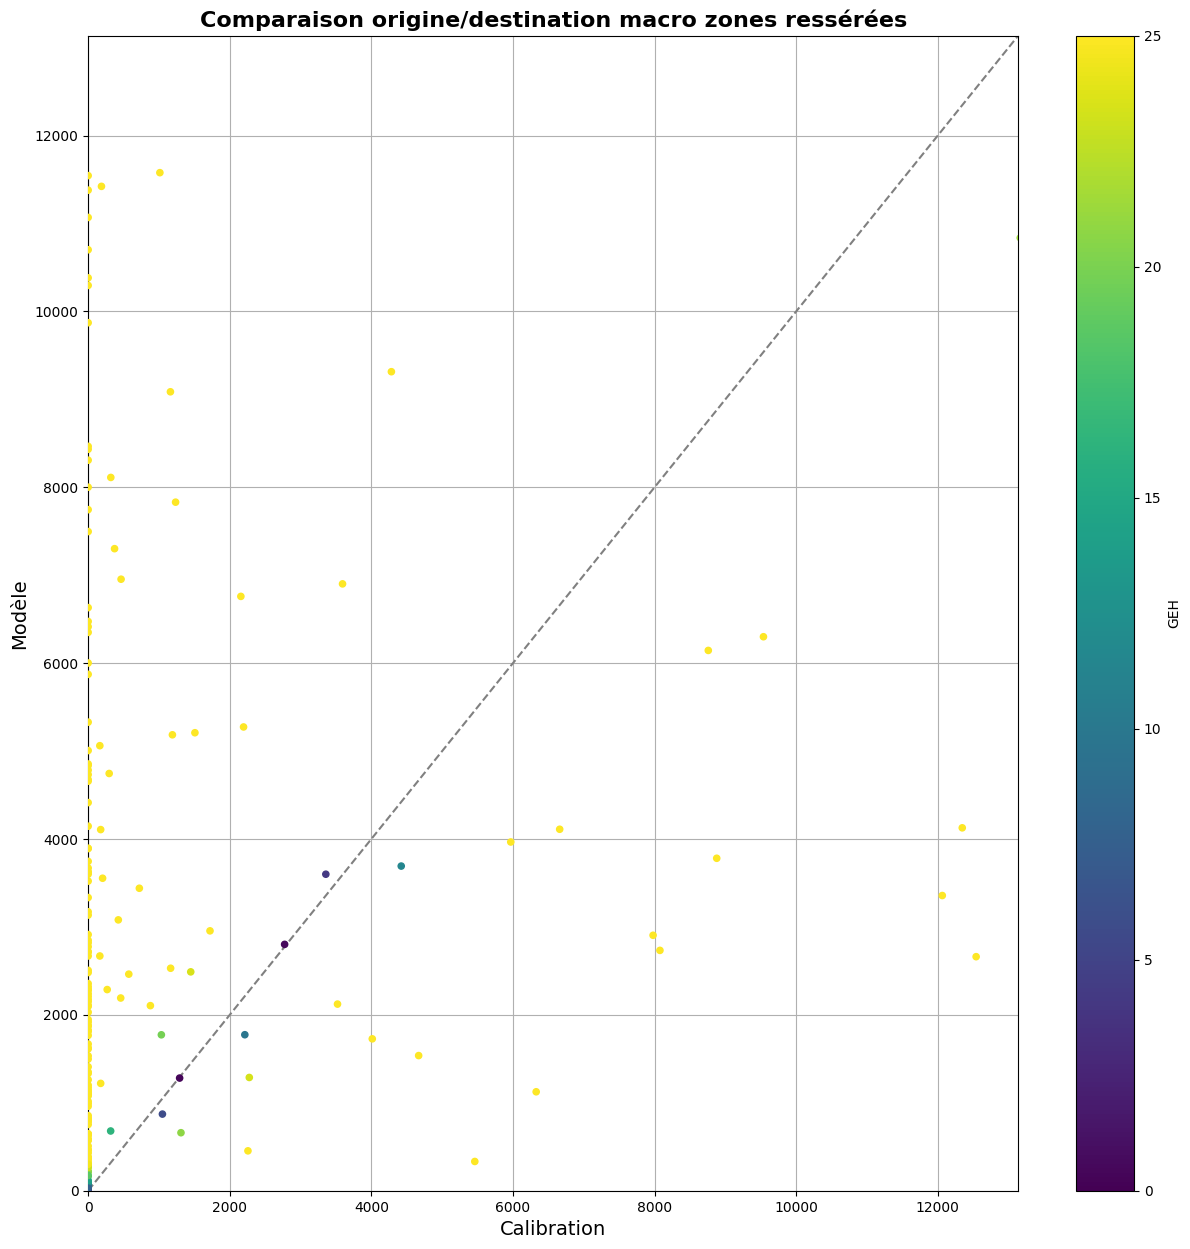

In [76]:
if calib_file_provided and macro_file_provided: 
    to_plot = comp_volumes_macro.set_index(['origin', 'destination'])
    ycol= 'volumes_model'
    xcol= 'volumes_calibration'
    to_plot['GEH'] = GEH(to_plot[ycol], to_plot[xcol])
    ax =  to_plot.plot.scatter(x=xcol, y=ycol, c='GEH', figsize=[15, 15], zorder=3, cmap='viridis', vmin=0, vmax=25)

    t = np.arange(0., max(to_plot[xcol].max(),to_plot[ycol].max()) +500, 1)
    plt.plot(t,t,linestyle='--',color="Grey", zorder=2)
    plt.xlim([0., max(to_plot[xcol].quantile(0.95),to_plot[ycol].quantile(0.95))+500])
    plt.ylim([0., max(to_plot[xcol].quantile(0.95),to_plot[ycol].quantile(0.95))+500])
    plt.xlabel('Calibration', fontsize=14)
    plt.ylabel('Modèle', fontsize=14)
    
    ax.grid(axis='both', zorder=3)
    plt.title('Comparaison origine/destination macro zones ressérées', loc='center', fontsize=16, fontweight="bold")
    fig = ax.get_figure()
    plt.savefig(output_folder+'Comparaison_od_ressérée.png',bbox_inches='tight', dpi=150)

In [77]:
if calib_file_provided and macro_file_provided: 
    comp_volumes_macro['delta'] = comp_volumes_macro['volumes_model'] - comp_volumes_macro['volumes_calibration']
    comp_volumes_macro[['origin', 'destination', 'delta']].set_index(['origin','destination']).unstack()

# distance

In [78]:
comp_volumes = comp_volumes.merge(distances[['origin', 'destination', 'euclidean_distance']],on = ["origin","destination"], how ="left")
comp_volumes_dist = comp_volumes.groupby('euclidean_distance')[columns].sum()

In [79]:
if calib_file_provided:
    comp_volumes_dist['volumes_model'] *= comp_volumes_dist['volumes_calibration'].sum() / comp_volumes_dist['volumes_model'].sum()
    comp_volumes_dist['volumes_calibration'] = comp_volumes_dist['volumes_calibration']/comp_volumes_dist['volumes_calibration'].sum()

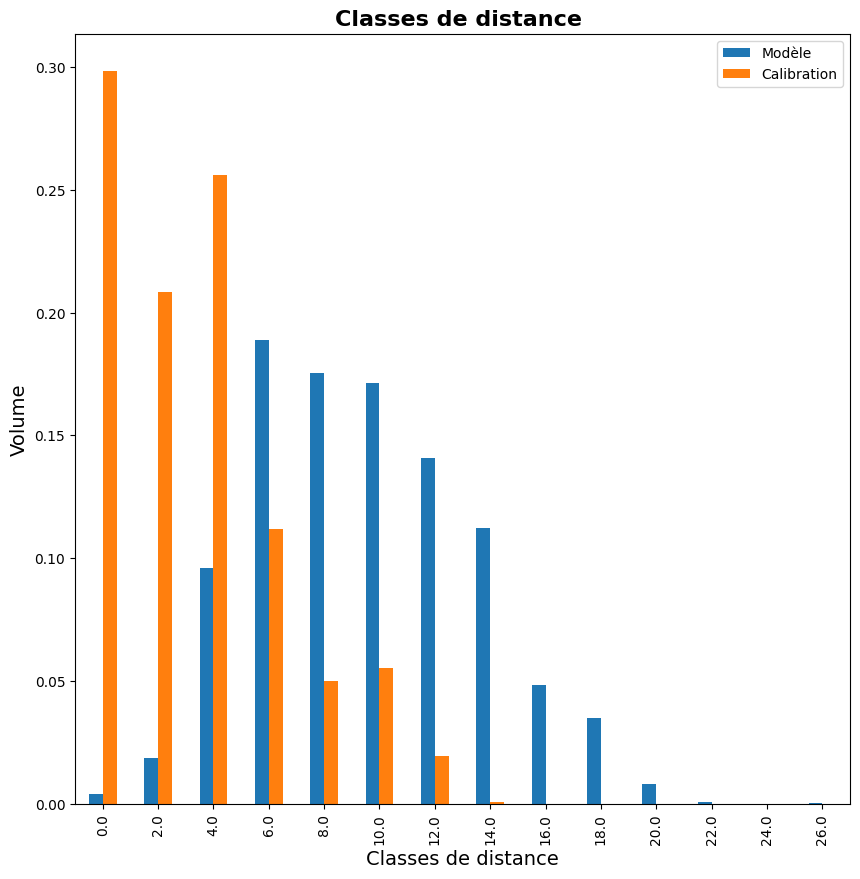

In [80]:
comp_volumes_dist['volumes_model'] = comp_volumes_dist['volumes_model']/comp_volumes_dist['volumes_model'].sum()

to_plot = comp_volumes_dist#.plot( kind = 'bar', figsize=[10, 10])
ax =  to_plot.plot.bar(figsize=[10, 10])
plt.ylabel('Volume', fontsize=14)
plt.xlabel('Classes de distance', fontsize=14)
plt.title('Classes de distance ', loc='center', fontsize=16, fontweight="bold")
plt.legend( ['Modèle', 'Calibration'])
fig = ax.get_figure()
plt.savefig(output_folder+'Comparaison_volumes_distances.png',bbox_inches='tight', dpi=150)


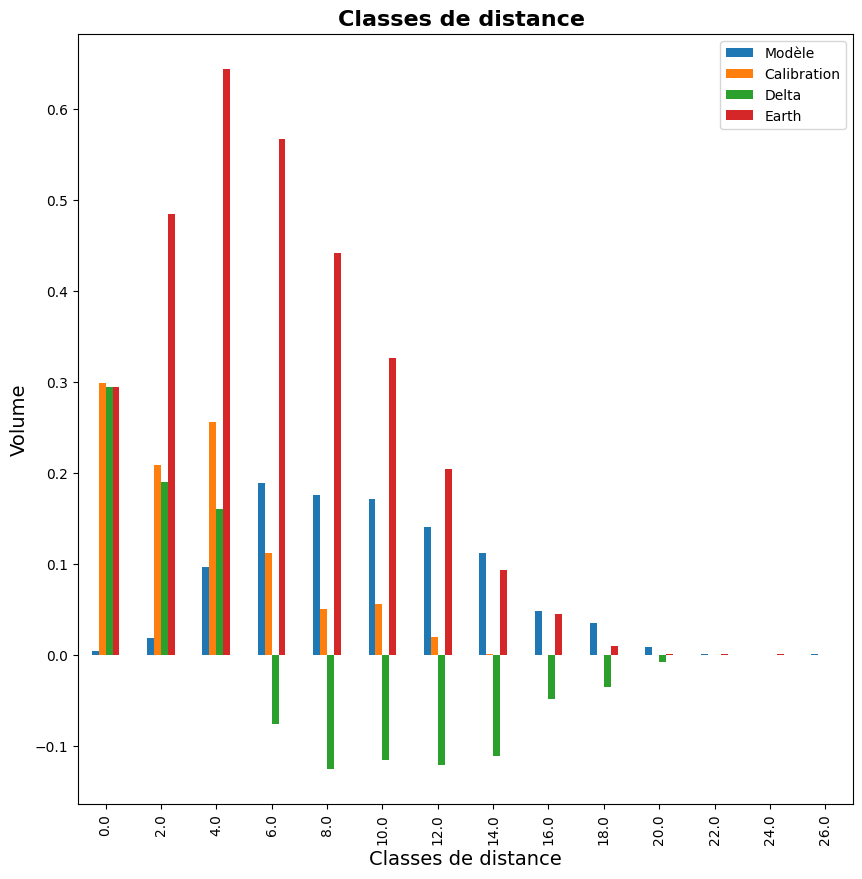

In [81]:
if calib_file_provided :    
    comp_volumes_dist['delta'] = comp_volumes_dist['volumes_calibration'].fillna(0) - comp_volumes_dist['volumes_model'].fillna(0)
    comp_volumes_dist ['earth'] = comp_volumes_dist['delta'].cumsum()
    to_plot = comp_volumes_dist#.plot( kind = 'bar', figsize=[10, 10])
    ax =  to_plot.plot.bar(figsize=[10, 10])
    plt.ylabel('Volume', fontsize=14)
    plt.xlabel('Classes de distance', fontsize=14)
    plt.title('Classes de distance ', loc='center', fontsize=16, fontweight="bold")
    plt.legend( ['Modèle', 'Calibration', 'Delta', 'Earth'])
    fig = ax.get_figure()
    plt.savefig(output_folder+'Comparaison_volumes_distances_earth.png',bbox_inches='tight', dpi=150)

In [82]:
end_of_notebook

NameError: name 'end_of_notebook' is not defined